In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy import stats
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
import time
import os
import h5py
from torchsummary import summary
from torchvision import transforms
from torch.utils import data
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split
from sklearn.preprocessing import normalize
from torchvision import transforms, datasets
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import torch.nn as nn
import random
import torch as T

In [2]:
# conda install tensorflow

In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Or, ignore specific warning
warnings.filterwarnings("ignore")

# Your code here


In [4]:
# Explore further into the extracted directory to find the dataset files
extract_dir = 'artificialWithAnomaly/'
# dataset_dir = os.path.join(extract_dir, 'artificialNoAnomaly')
os.listdir(extract_dir)

['art_daily_flatmiddle.csv',
 'art_daily_jumpsdown.csv',
 'art_daily_jumpsup.csv',
 'art_load_balancer_spikes.csv',
 'art_increase_spike_density.csv',
 'art_daily_nojump.csv']

In [5]:
# Load and preview each dataset to understand their structure and content
dataset_dir = extract_dir
file_paths = [os.path.join(dataset_dir, file_name) for file_name in os.listdir(dataset_dir)]
datasets = {file_name.split('.')[0]: pd.read_csv(filepath) for file_name, filepath in zip(os.listdir(dataset_dir), file_paths)}

# Display basic information and the first few rows of each dataset to understand their content
for name, df in datasets.items():
    print(f"Dataset: {name}")
    print(df.info())
    print(df.head(), "\n")

# Select one dataset based on its structure and content for further analysis and preprocessing
# For demonstration, let's pick the first dataset and explore it further
chosen_dataset_name = list(datasets.keys())[0]
chosen_dataset = datasets[chosen_dataset_name]

chosen_dataset.head()


Dataset: art_daily_flatmiddle
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None
             timestamp      value
0  2014-04-01 00:00:00 -21.048383
1  2014-04-01 00:05:00 -20.295477
2  2014-04-01 00:10:00 -18.127229
3  2014-04-01 00:15:00 -20.171665
4  2014-04-01 00:20:00 -21.223762 

Dataset: art_daily_jumpsdown
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB
None
             timestamp      value
0  2014-04-01 00:00:00  18.090486
1  2014-04-01 00:05

,timestamp,value
0,2014-04-01 00:00:00,-21.048383
1,2014-04-01 00:05:00,-20.295477
2,2014-04-01 00:10:00,-18.127229
3,2014-04-01 00:15:00,-20.171665
4,2014-04-01 00:20:00,-21.223762


In [6]:
chosen_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


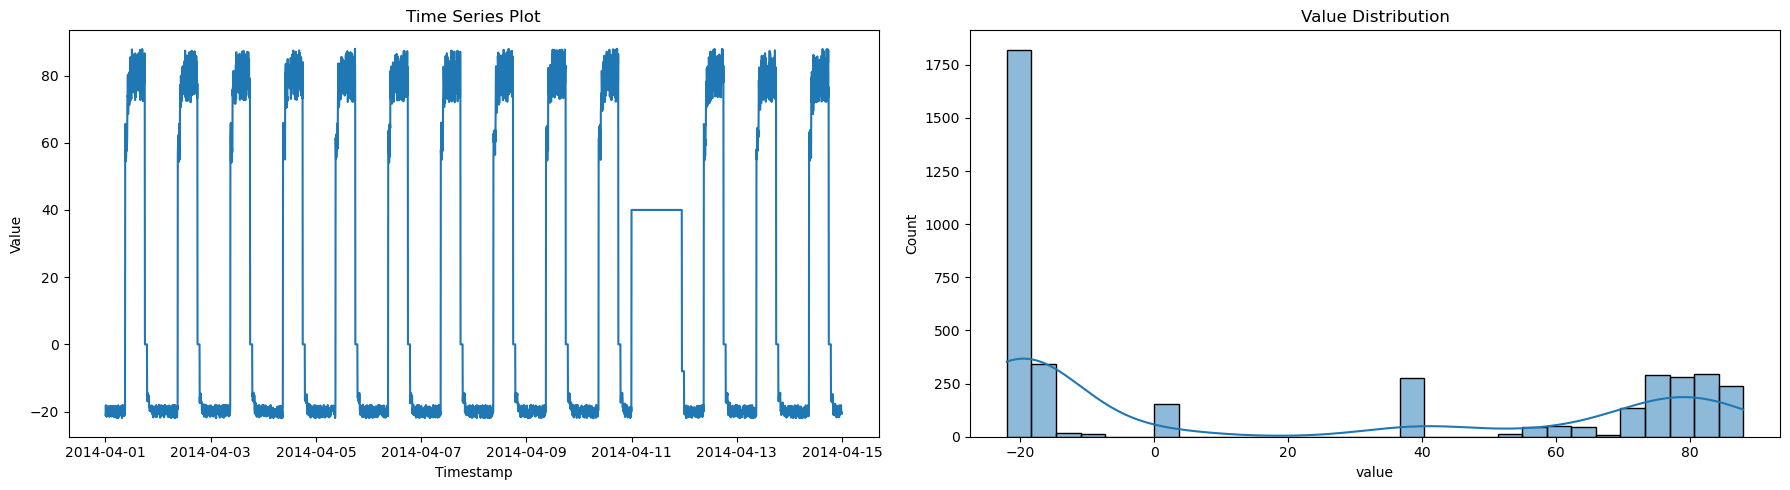

count    4032.000000
mean       18.981142
std        45.374171
min       -21.998789
25%       -19.929162
50%       -17.541296
75%        74.425223
max        87.958348
Name: value, dtype: float64

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'timestamp' to datetime
chosen_dataset['timestamp'] = pd.to_datetime(chosen_dataset['timestamp'])

# Statistical summary of 'value'
stat_summary = chosen_dataset['value'].describe()

# Plotting
plt.figure(figsize=(18, 5))

# Time series plot
plt.subplot(1, 2, 1)
plt.plot(chosen_dataset['timestamp'], chosen_dataset['value'])
plt.title('Time Series Plot')
plt.xlabel('Timestamp')
plt.ylabel('Value')

# Distribution plot
plt.subplot(1, 2, 2)
sns.histplot(chosen_dataset['value'], bins=30, kde=True)
plt.title('Value Distribution')

plt.tight_layout()
plt.show()

stat_summary


In [8]:
chosen_dataset = chosen_dataset.set_index('timestamp')

In [9]:
chosen_dataset

,value
timestamp,
2014-04-01 00:00:00,-21.048383
2014-04-01 00:05:00,-20.295477
2014-04-01 00:10:00,-18.127229
2014-04-01 00:15:00,-20.171665
2014-04-01 00:20:00,-21.223762
...,...
2014-04-14 23:35:00,-18.083562
2014-04-14 23:40:00,-20.278406
2014-04-14 23:45:00,-20.063239


In [10]:
# 5 Mins bucket size, so each day has around 288 entries
period = 24 * 12
chosen_dataset.isna().sum()

value    0
dtype: int64

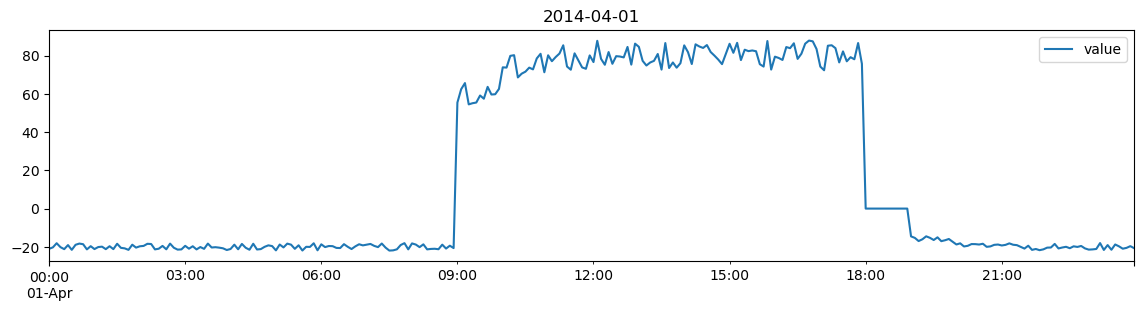

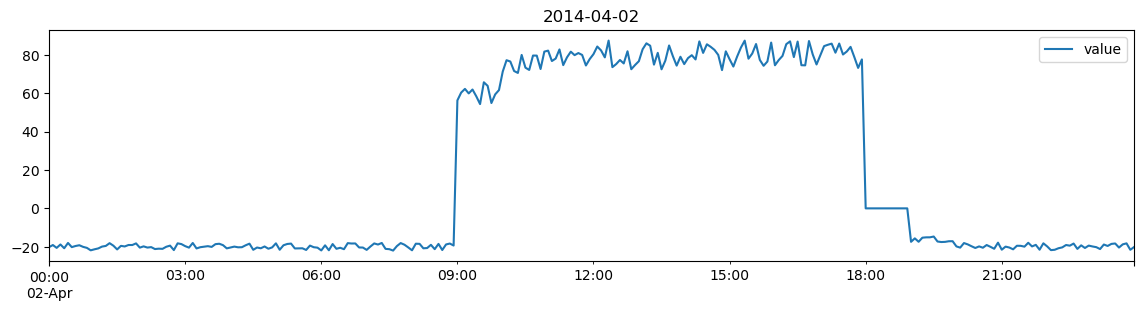

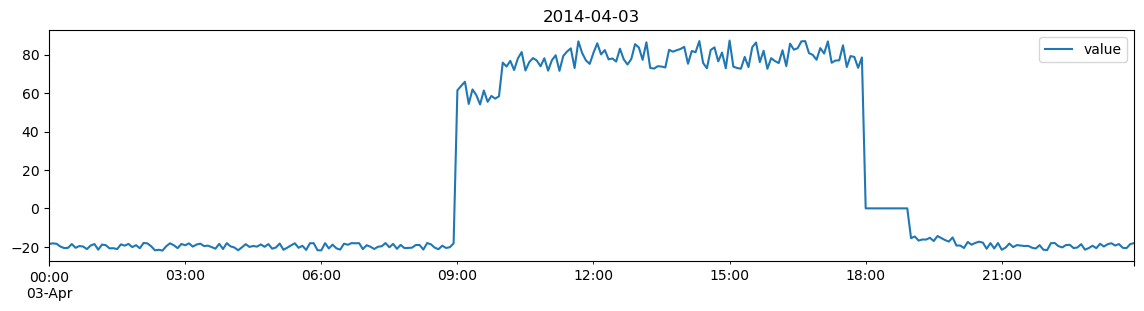

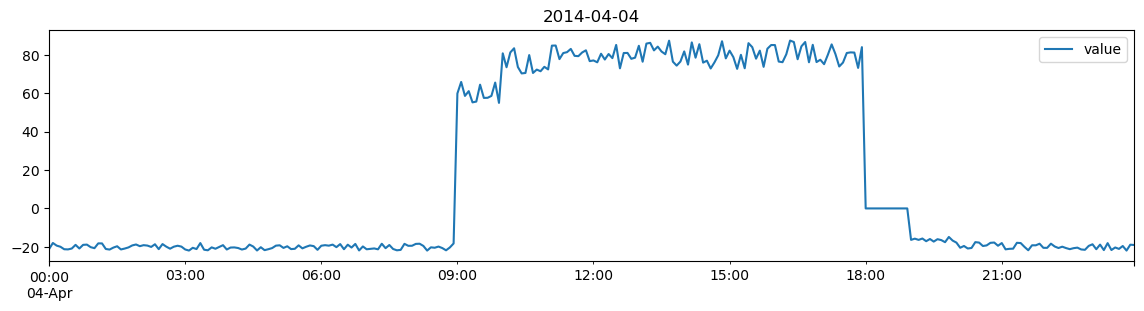

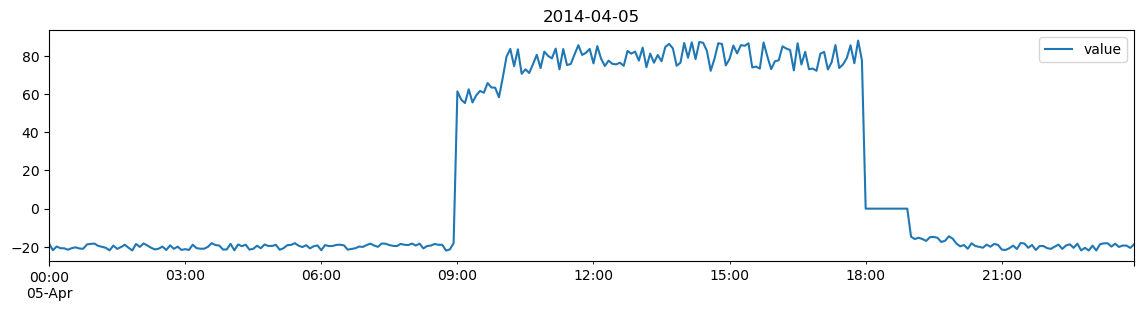

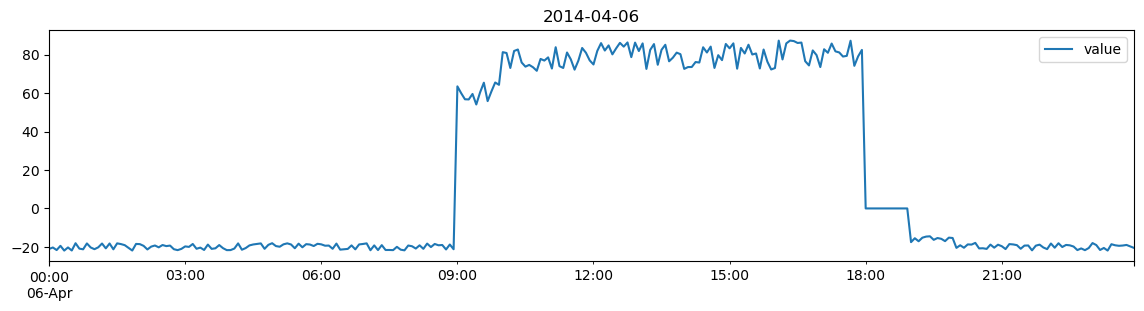

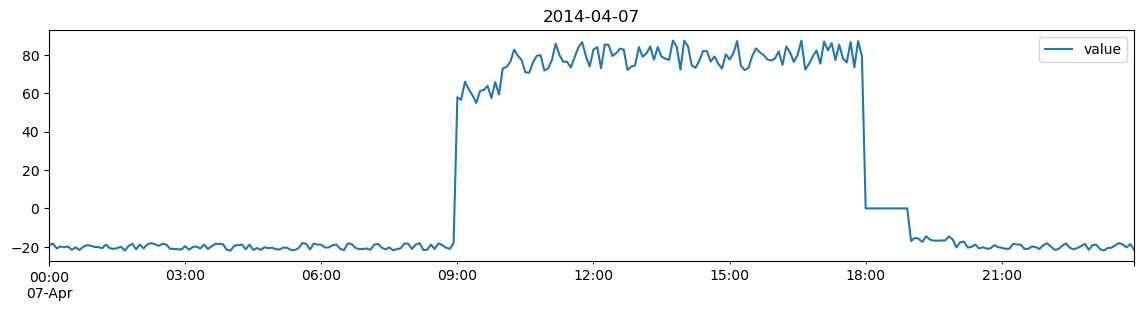

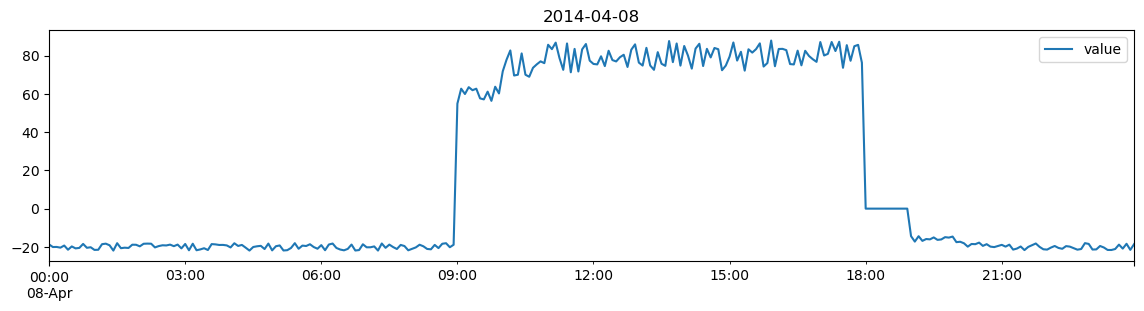

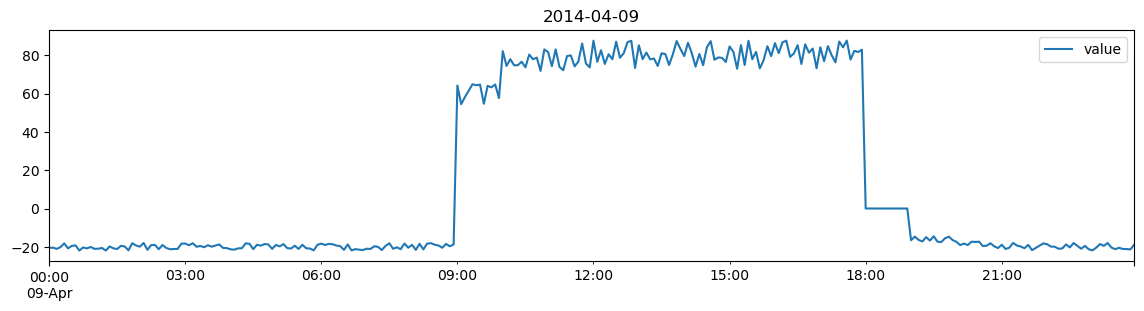

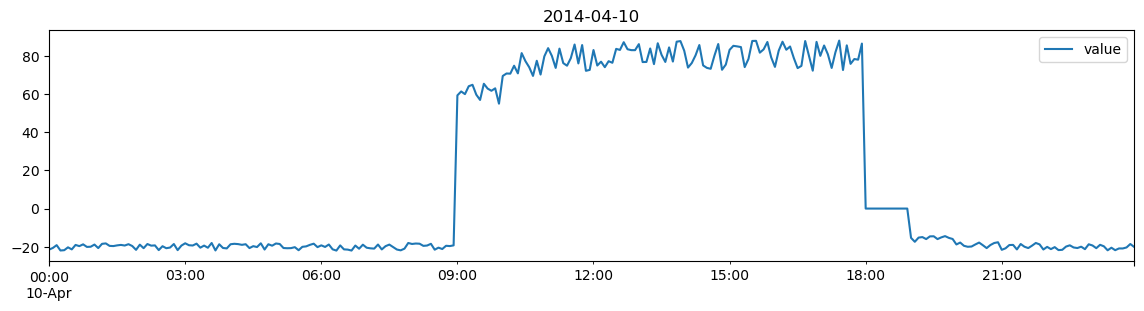

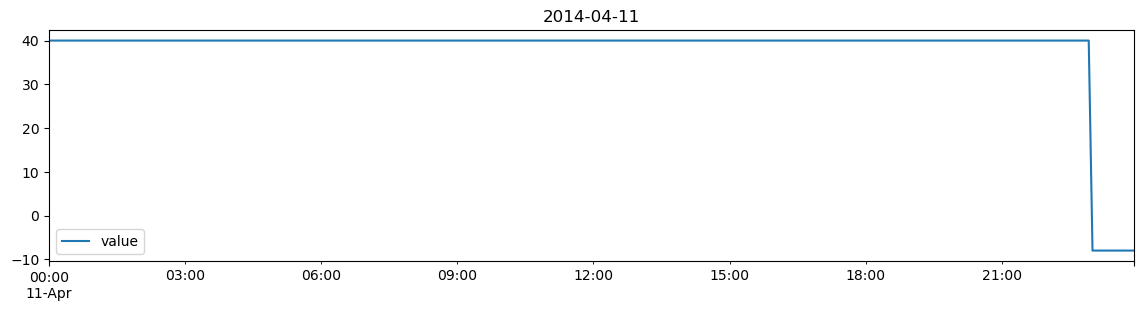

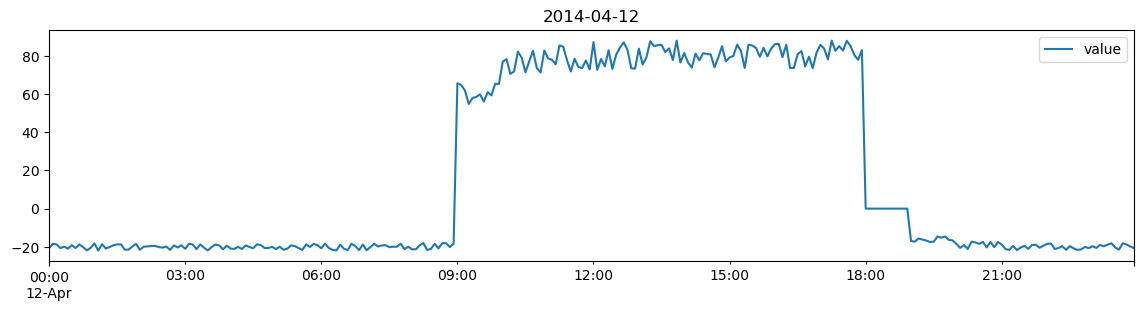

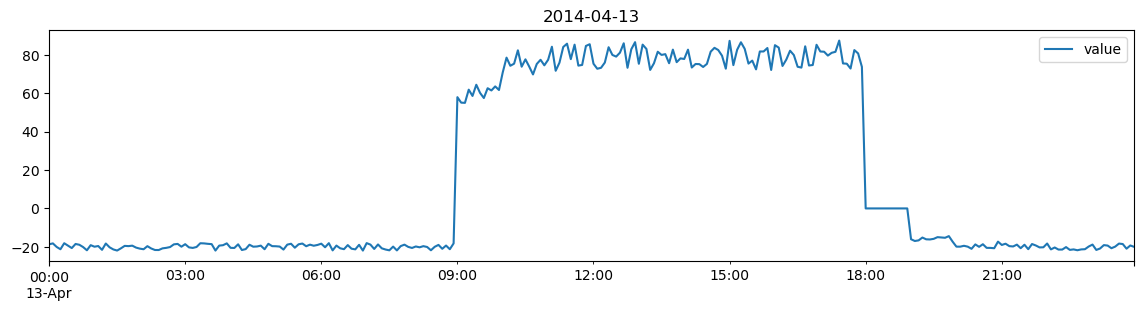

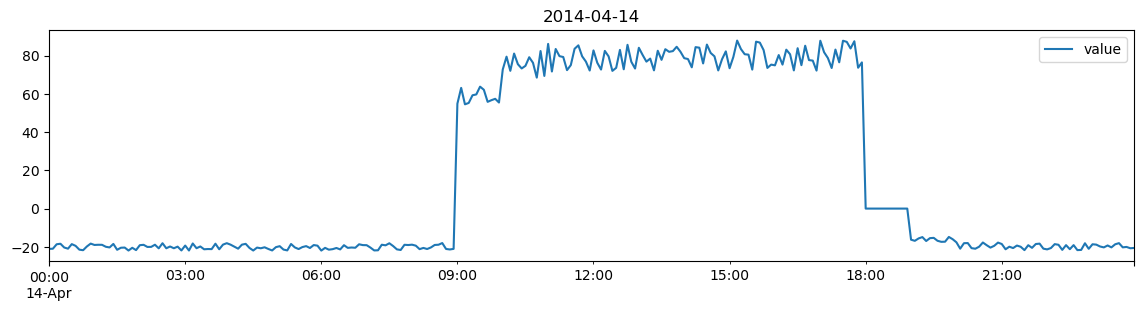

In [11]:
for i in range(len(chosen_dataset)//period):
    chosen_dataset[period*i:period*(i + 1)].plot(figsize=(14, 3), title=str(chosen_dataset.index[period * i])[:10])
    plt.xlabel(None)
    plt.show()

In [12]:
def createDataframe(dataset, date_indices, period=1):
    new_df = []
    idxs = []
    for i in range(int(len(dataset) / period)):
        value = dataset.iloc[i * period: (i + 1) * period].values
        idxs.append(date_indices[period * i])
        new_df.append(value)
    return np.array(new_df), np.array(idxs)

df, dates = createDataframe(chosen_dataset.value, chosen_dataset.index, period)
df = pd.DataFrame(df, dates)
print('New df shape: ', df.shape)
df.head()

New df shape:  (14, 288)


,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
2014-04-01,-21.048383,-20.295477,-18.127229,-20.171665,-21.223762,-19.104491,-21.589446,-18.945042,-18.305893,-18.639757,...,-18.049373,-21.640595,-19.093391,-21.544999,-18.781860,-19.752260,-20.990876,-20.554536,-19.657395,-20.707867
2014-04-02,-20.195798,-19.102945,-20.585318,-18.816988,-20.775953,-18.012444,-20.195090,-19.604271,-19.212415,-20.062832,...,-21.200623,-18.838595,-19.588791,-18.514400,-18.297185,-20.412163,-18.750362,-18.233361,-21.581483,-20.130814
2014-04-03,-18.538513,-18.213705,-18.479440,-19.885349,-20.673861,-20.565120,-18.577692,-20.533956,-19.619462,-19.858975,...,-18.444708,-19.866665,-18.669961,-18.159912,-19.347112,-18.596989,-20.527501,-20.689649,-18.588819,-18.092661
2014-04-04,-21.171242,-18.008228,-19.375652,-19.978333,-21.274569,-21.354235,-20.899758,-18.988790,-20.880748,-18.986157,...,-18.848979,-21.708854,-18.085723,-21.678146,-20.350218,-21.092217,-19.587700,-21.959836,-18.904154,-19.051276
2014-04-05,-18.205730,-21.761893,-19.824117,-20.699410,-20.749763,-21.498008,-20.659701,-20.248085,-20.841274,-21.003883,...,-18.576303,-18.156967,-18.126134,-19.853126,-18.326151,-20.042256,-19.303823,-19.336326,-20.535862,-18.646423


In [13]:
train_size = int(0.7 * len(df))  # 70% of the data for training
val_size = int(0.15 * len(df))   # 15% of the data for validation
test_size = len(df) - train_size - val_size  # Remaining for testing

indices = np.random.permutation(len(df))

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

X_train = df[:train_size]
X_val = df[train_size:train_size+val_size]
X_test = df[train_size+val_size:]

dates_train = np.array(df.index[:train_size], dtype='datetime64[D]')
dates_val = np.array(df.index[train_size:train_size+val_size], dtype='datetime64[D]')
dates_test = np.array(df.index[train_size+val_size:], dtype='datetime64[D]')

In [14]:
X_val

,0,1,2,3,4,5,6,7,8,9,...,278,279,280,281,282,283,284,285,286,287
2014-04-10,-21.485074,-20.616376,-19.158902,-21.949179,-21.80073,-20.297764,-21.372834,-19.045978,-19.664148,-18.735887,...,-18.98066,-19.753056,-21.847941,-20.496943,-21.789254,-20.883081,-20.89198,-20.360911,-18.562892,-20.072432
2014-04-11,40.000000,40.000000,40.000000,40.000000,40.00000,40.000000,40.000000,40.000000,40.000000,40.000000,...,-8.00000,-8.000000,-8.000000,-8.000000,-8.000000,-8.000000,-8.00000,-8.000000,-8.000000,-8.000000


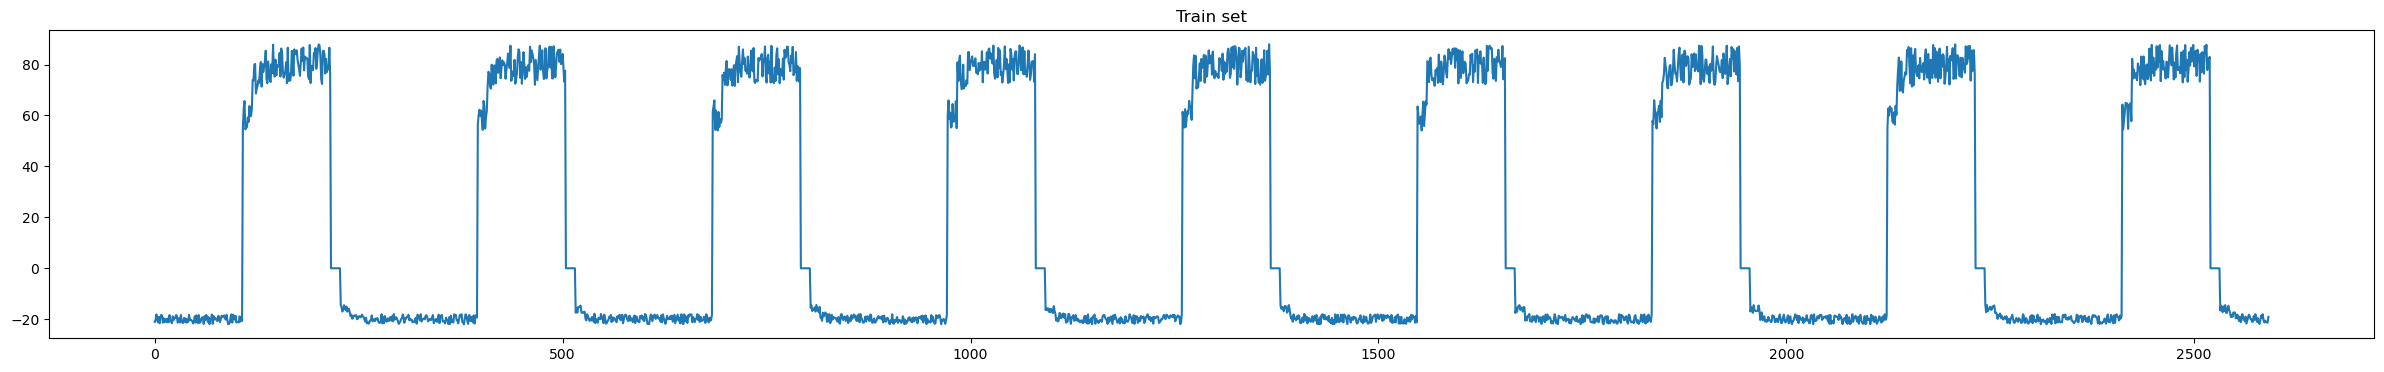

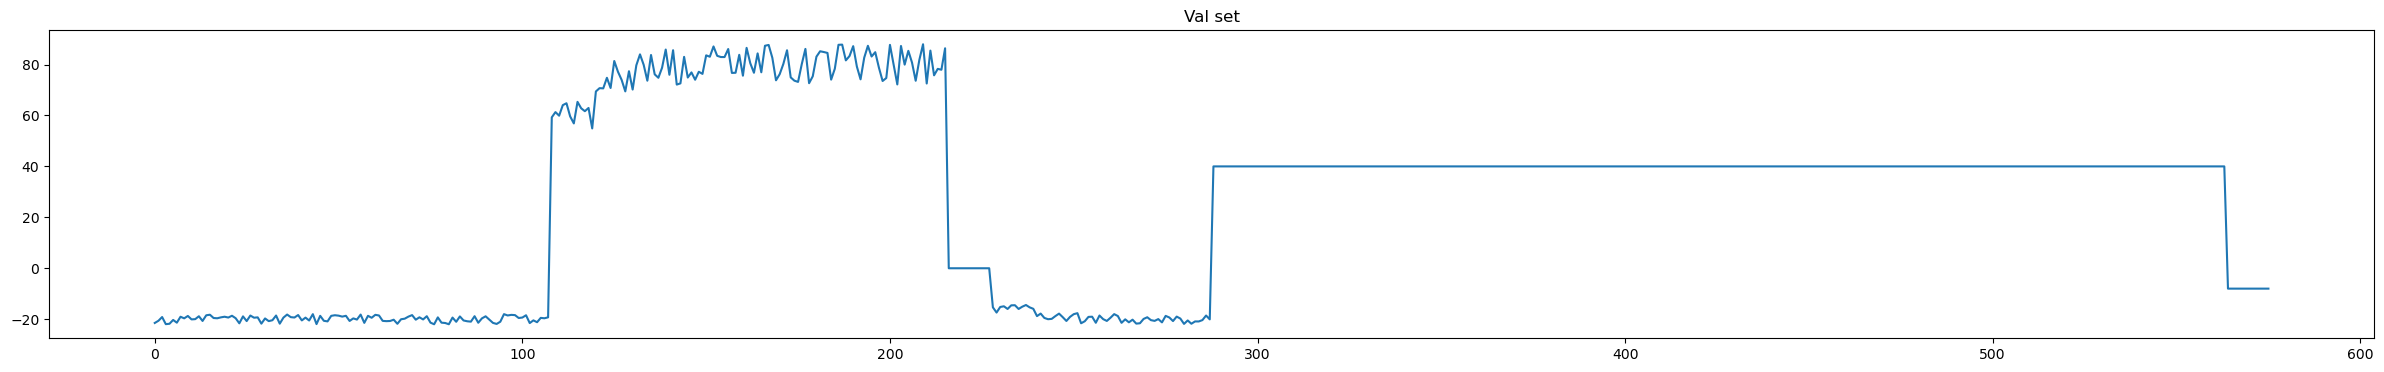

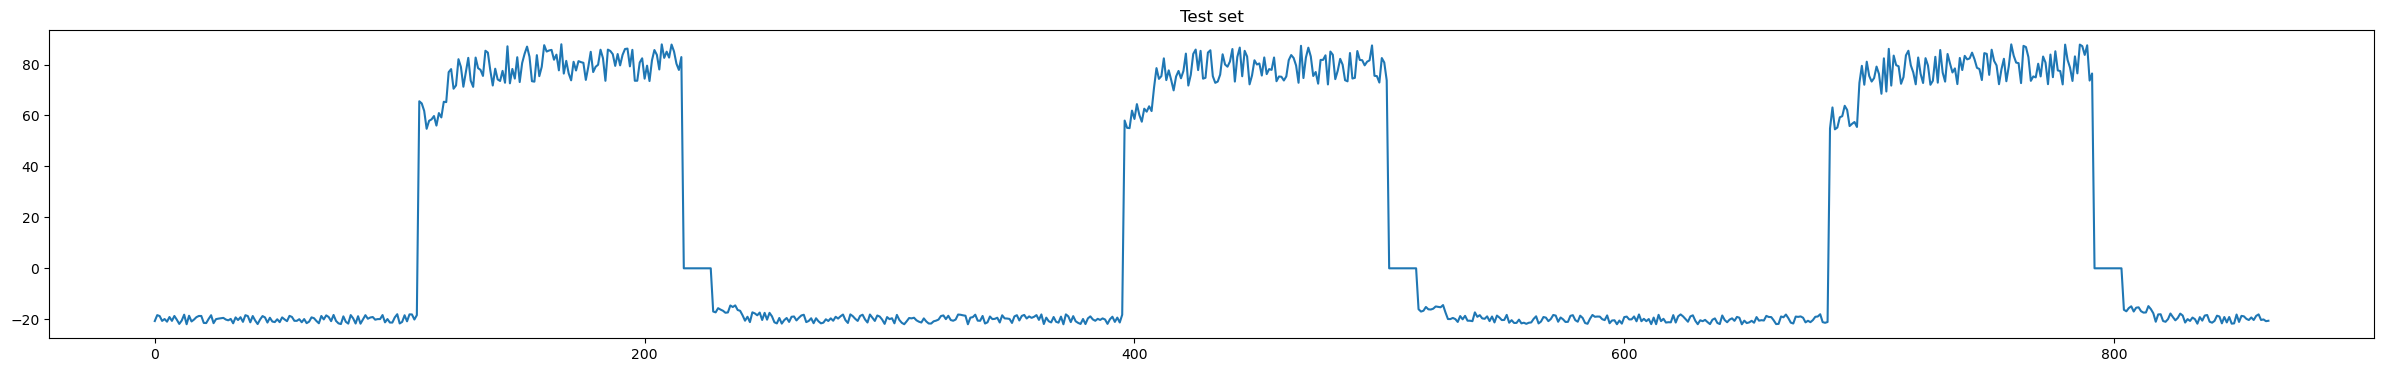

In [15]:
plt.figure(figsize=(30,4))
plt.title('Train set')
plt.plot(X_train.to_numpy().flatten())
plt.show()

plt.figure(figsize=(30,4))
plt.title('Val set')
plt.plot(X_val.to_numpy().flatten())
plt.show()

plt.figure(figsize=(30,4))
plt.title('Test set')
plt.plot(X_test.to_numpy().flatten())
plt.show()

In [16]:
# Normalizing data
scaler = StandardScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Autoencoder basic model

In [17]:
dim_hidden1 = 144

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(288, dim_hidden1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden1, 288),
            nn.ReLU(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
# Training
X_train_tensor = torch.Tensor(X_train) 
X_test_tensor = torch.Tensor(X_test)
X_val_tensor = torch.Tensor(X_val)
train_loader = T.utils.data.DataLoader(X_train_tensor, batch_size=20,shuffle=True)
val_loader = T.utils.data.DataLoader(X_val_tensor, batch_size=20,shuffle=False)
test_loader = T.utils.data.DataLoader(X_test_tensor, batch_size=20,shuffle=False)
autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
batch_size = 20
epochs = 50

def train(model, train_loader, val_loader, criterion, optimizer, nepochs=20):
  model.train()
  print('\n Training started')
  train_losses = []
  val_losses = []
  train_r2 = []
  val_r2 = []
  for epoch in range(nepochs):
    running_loss = 0.0
    for (batch_idx, batch) in enumerate(train_loader):
      X = batch
      Y = batch
      optimizer.zero_grad()               
      oupt = model(X)                   
      loss_val = criterion(oupt, Y)  
      running_loss += loss_val.item()  
      loss_val.backward()           
      optimizer.step()
    train_losses.append(running_loss/len(X_train_tensor))
    # print(oupt.detach().cpu().numpy().shape)
    # print(X.detach().cpu().numpy().shape)
    train_r2.append(r2_score(oupt.detach().cpu().numpy(), X.detach().cpu().numpy()))

    model.eval()
    eval_loss = 0.0
    for (batch_idx, batch) in enumerate(val_loader):
      X = batch
      Y = batch
      output = model(X)
      vloss = criterion(output, Y)
      eval_loss += vloss.item()
      val_losses.append(eval_loss/len(X_val_tensor))
      val_r2.append(r2_score(output.detach().cpu().numpy(), X.detach().cpu().numpy()))
      
    if epoch % 1 == 0:
        print("epoch = %4d \nTrain loss = %0.4f" % (epoch, running_loss/len(X_train_tensor)))
        print('val loss',eval_loss/len(X_val_tensor))

  return train_losses, val_losses, train_r2, val_r2

train_losses, val_losses, train_r2, val_r2 = train(autoencoder, train_loader, val_loader, criterion, optimizer, epochs)



 Training started
epoch =    0 
Train loss = 0.1148
val loss 57269735653376.0
epoch =    1 
Train loss = 0.1012
val loss 56761356648448.0
epoch =    2 
Train loss = 0.0880
val loss 56714724376576.0
epoch =    3 
Train loss = 0.0830
val loss 56908979372032.0
epoch =    4 
Train loss = 0.0813
val loss 56942139539456.0
epoch =    5 
Train loss = 0.0823
val loss 56767014764544.0
epoch =    6 
Train loss = 0.0814
val loss 56651340054528.0
epoch =    7 
Train loss = 0.0808
val loss 56685255196672.0
epoch =    8 
Train loss = 0.0806
val loss 56659741245440.0
epoch =    9 
Train loss = 0.0805
val loss 56579680370688.0
epoch =   10 
Train loss = 0.0803
val loss 56538211287040.0
epoch =   11 
Train loss = 0.0800
val loss 56558125842432.0
epoch =   12 
Train loss = 0.0799
val loss 56573699293184.0
epoch =   13 
Train loss = 0.0798
val loss 56509320921088.0
epoch =   14 
Train loss = 0.0797
val loss 56444103688192.0
epoch =   15 
Train loss = 0.0796
val loss 56417172062208.0
epoch =   16 
Train l

In [19]:
# Computing Test loss
autoencoder.eval()

with torch.no_grad():
    X_reconstructed = autoencoder(X_test_tensor)
    test_loss = criterion(X_reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")
    X_reconstructed_flat = X_reconstructed.view(-1).cpu().numpy()
    X_test_flat = X_test_tensor.view(-1).cpu().numpy()
    r2 = r2_score(X_test_flat, X_reconstructed_flat)
    print(f"R2 Score: {r2}")
    # print(r2_score(X_reconstructed.detach().cpu().numpy(), X_test_tensor.detach().cpu().numpy()))


Test Loss: 1.523915410041809
R2 Score: -0.003650547707805263


#### Threshold and identifying anomalies in validation set

In [20]:
reconstruction_errors = []
autoencoder.eval()
with torch.no_grad():
    for data in val_loader:
        reconstructed = autoencoder(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())
        
threshold = np.quantile(reconstruction_errors, 0.95)


In [21]:
anomalies_val = []
with torch.no_grad():
    for data in val_loader:
        reconstructed = autoencoder(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_val.extend(is_anomaly.cpu().numpy())

In [22]:
print(np.array(dates_val[anomalies_val]))

['2014-04-11']


#### Identifying anomalies in test set

In [23]:
anomalies_test = []
with torch.no_grad():
    for data in test_loader:
        reconstructed = autoencoder(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_test.extend(is_anomaly.cpu().numpy())

In [24]:
print(np.array(dates_test[anomalies_test]))

[]


### Plots for basic model

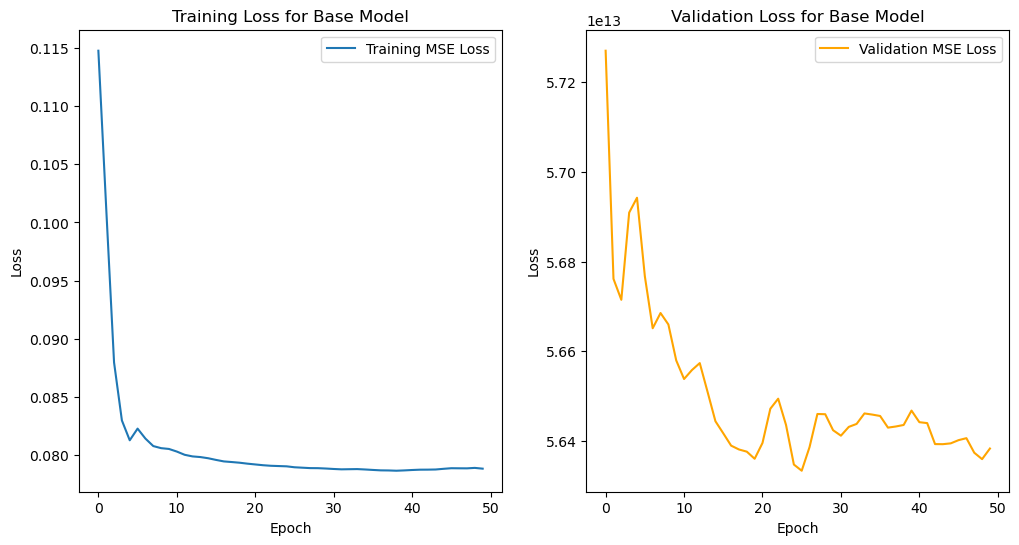

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(train_losses, label='Training MSE Loss')
ax[0].set_title('Training Loss for Base Model')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_losses, label='Validation MSE Loss', color='orange')
ax[1].set_title('Validation Loss for Base Model')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

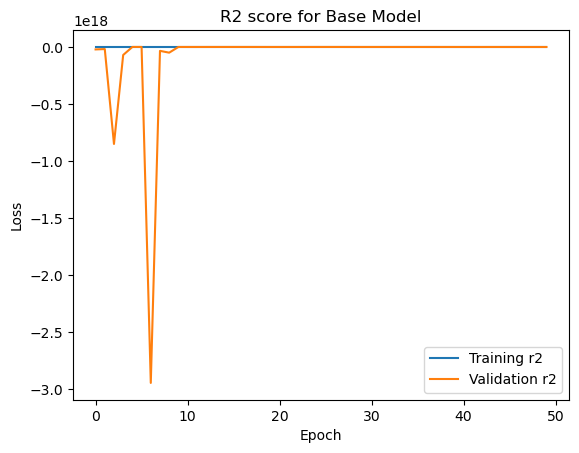

In [26]:
plt.plot(train_r2, label='Training r2')
plt.plot(val_r2, label='Validation r2')
plt.title('R2 score for Base Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

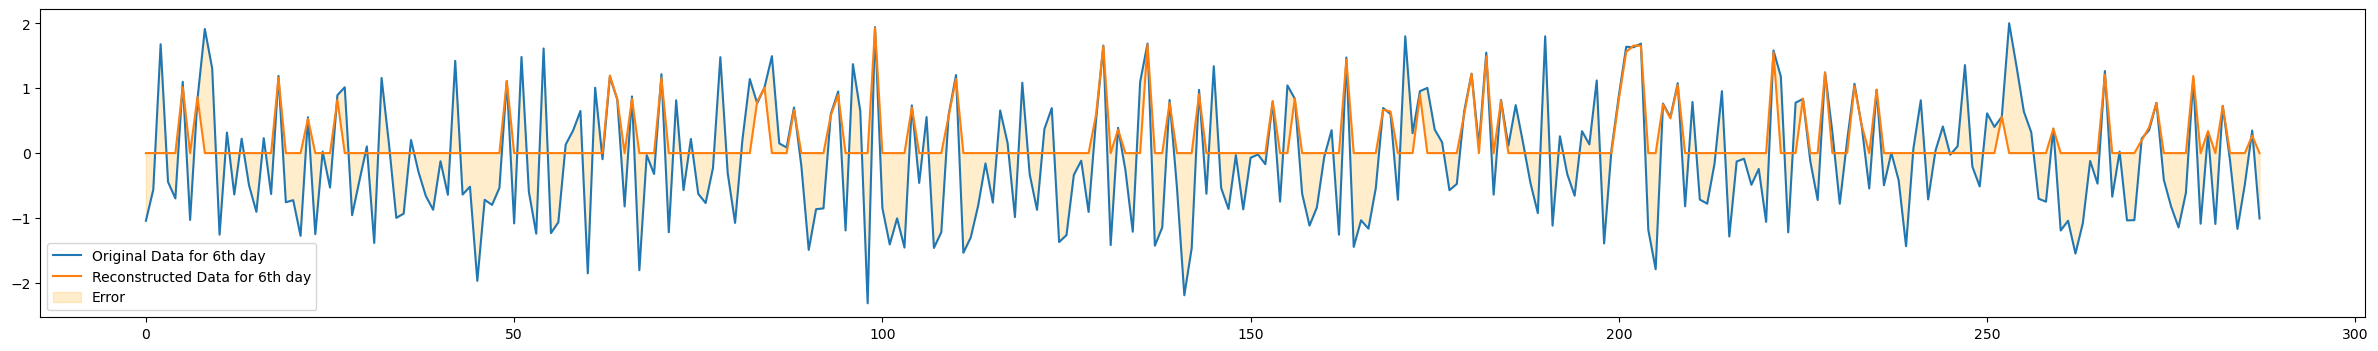

Error (MSE):  0.680251


In [27]:
# Converting X_train to tensor
if isinstance(X_train, np.ndarray):
    X_train_tensor = torch.from_numpy(X_train).float()
else:
    X_train_tensor = X_train.float()  

# Converting X_test to tensor
if isinstance(X_test, np.ndarray):
    X_test_tensor = torch.from_numpy(X_test).float()
else:
    X_test_tensor = X_test.float() 


encoded_data = autoencoder.encoder(X_train_tensor).detach()
decoded_data = autoencoder.decoder(encoded_data).detach()

i = 0
X_train_np = X_train_tensor.cpu().numpy() if X_train_tensor.is_cuda else X_train_tensor.numpy()
decoded_data_np = decoded_data.cpu().numpy() if decoded_data.is_cuda else decoded_data.numpy()


X_train_np = X_train_tensor.numpy()
decoded_data_np = decoded_data.numpy()

plt.figure(figsize=(30,4))
plt.plot(X_train_np[i], label='Original Data for 6th day')
plt.plot(decoded_data_np[i], label='Reconstructed Data for 6th day')
plt.fill_between(np.arange(len(X_train_np[i])), decoded_data_np[i], X_train_np[i], color='orange', alpha=0.2, label='Error')
plt.legend()
plt.show()

# Calculate the error (MSE)
mse_error = np.mean((X_train_np[i] - decoded_data_np[i]) ** 2)
print('Error (MSE): ', mse_error)

### Autoencoder: Dense Layer

In [28]:
dim_hidden1 = 144
dim_hidden2 = 72
dim_hidden3 = 36
dim_hidden4 = 18
dim_hidden5 = 9

class AutoencoderDense(nn.Module):
    def __init__(self):
        super(AutoencoderDense, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(288, dim_hidden1),
            nn.ReLU(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.ReLU(),
            nn.Linear(dim_hidden2, dim_hidden3),
            nn.ReLU(),
            nn.Linear(dim_hidden3, dim_hidden4),
            nn.ReLU(),
            nn.Linear(dim_hidden4, dim_hidden5),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden5, dim_hidden4),
            nn.ReLU(),
            nn.Linear(dim_hidden4, dim_hidden3),
            nn.ReLU(),
            nn.Linear(dim_hidden3, dim_hidden2),
            nn.ReLU(),
            nn.Linear(dim_hidden2, dim_hidden1),
            nn.ReLU(),
            nn.Linear(dim_hidden1, 288),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [29]:
dense = AutoencoderDense()
criterion_dense = nn.MSELoss()
optimizer_dense = optim.Adam(dense.parameters(), lr=0.01)
batch_size = 20
epochs = 50

train_losses, val_losses, train_r2, val_r2 = train(dense, train_loader, val_loader, criterion_dense, optimizer_dense, epochs)


 Training started
epoch =    0 
Train loss = 0.1115
val loss 56855904649216.0
epoch =    1 
Train loss = 0.1112
val loss 56855787208704.0
epoch =    2 
Train loss = 0.1111
val loss 56863613779968.0
epoch =    3 
Train loss = 0.1110
val loss 56866927280128.0
epoch =    4 
Train loss = 0.1106
val loss 56881766727680.0
epoch =    5 
Train loss = 0.1089
val loss 56914738151424.0
epoch =    6 
Train loss = 0.1043
val loss 57063401062400.0
epoch =    7 
Train loss = 0.1037
val loss 56732197847040.0
epoch =    8 
Train loss = 0.0965
val loss 56691085279232.0
epoch =    9 
Train loss = 0.0934
val loss 56621505970176.0
epoch =   10 
Train loss = 0.0911
val loss 56424918941696.0
epoch =   11 
Train loss = 0.0870
val loss 56430786772992.0
epoch =   12 
Train loss = 0.0844
val loss 56737809825792.0
epoch =   13 
Train loss = 0.0805
val loss 56755232964608.0
epoch =   14 
Train loss = 0.0747
val loss 56759653761024.0
epoch =   15 
Train loss = 0.0720
val loss 56709334695936.0
epoch =   16 
Train l

In [30]:
# Computing Test loss
dense.eval()

with torch.no_grad():
    X_reconstructed = dense(X_test_tensor)
    test_loss = criterion_dense(X_reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")
    X_reconstructed_flat = X_reconstructed.view(-1).cpu().numpy()
    X_test_flat = X_test_tensor.view(-1).cpu().numpy()
    r2 = r2_score(X_test_flat, X_reconstructed_flat)
    print(f"R2 Score: {r2}")
    # print(r2_score(X_reconstructed.detach().cpu().numpy(), X_test_tensor.detach().cpu().numpy()))


Test Loss: 2.0110275745391846
R2 Score: -0.32446240165668505


In [31]:
reconstruction_errors = []
dense.eval()
with torch.no_grad():
    for data in val_loader:
        reconstructed = dense(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())
        
threshold = np.quantile(reconstruction_errors, 0.95)

anomalies_val = []
with torch.no_grad():
    for data in val_loader:
        reconstructed = dense(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_val.extend(is_anomaly.cpu().numpy())
print(np.array(dates_val[anomalies_val]))

['2014-04-11']


In [32]:
anomalies_test = []
with torch.no_grad():
    for data in test_loader:
        reconstructed = dense(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_test.extend(is_anomaly.cpu().numpy())
print(np.array(dates_test[anomalies_test]))

[]


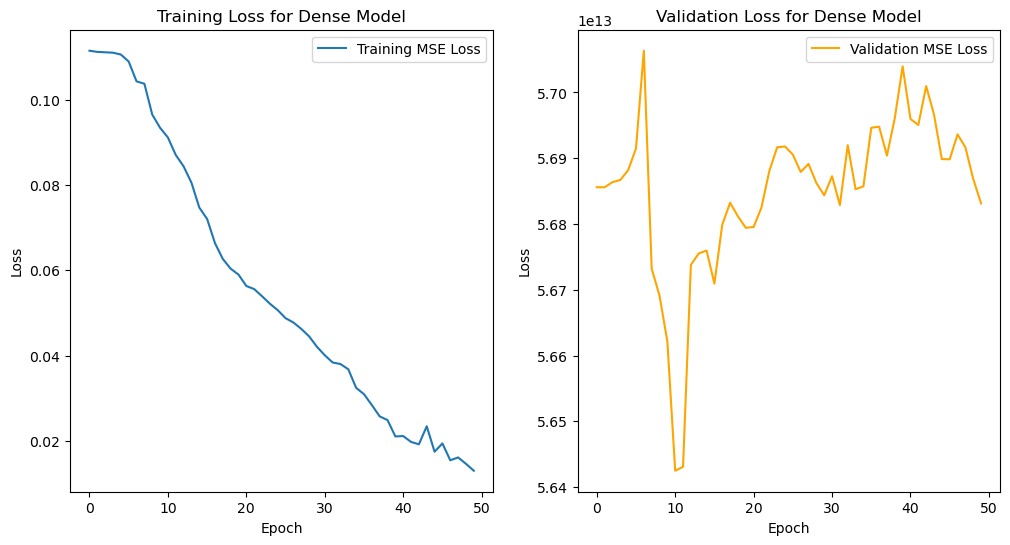

In [33]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(train_losses, label='Training MSE Loss')
ax[0].set_title('Training Loss for Dense Model')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_losses, label='Validation MSE Loss', color='orange')
ax[1].set_title('Validation Loss for Dense Model')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

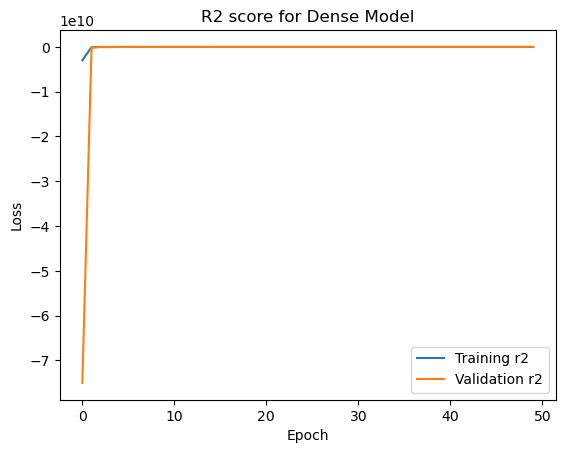

In [34]:
plt.plot(train_r2, label='Training r2')
plt.plot(val_r2, label='Validation r2')
plt.title('R2 score for Dense Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

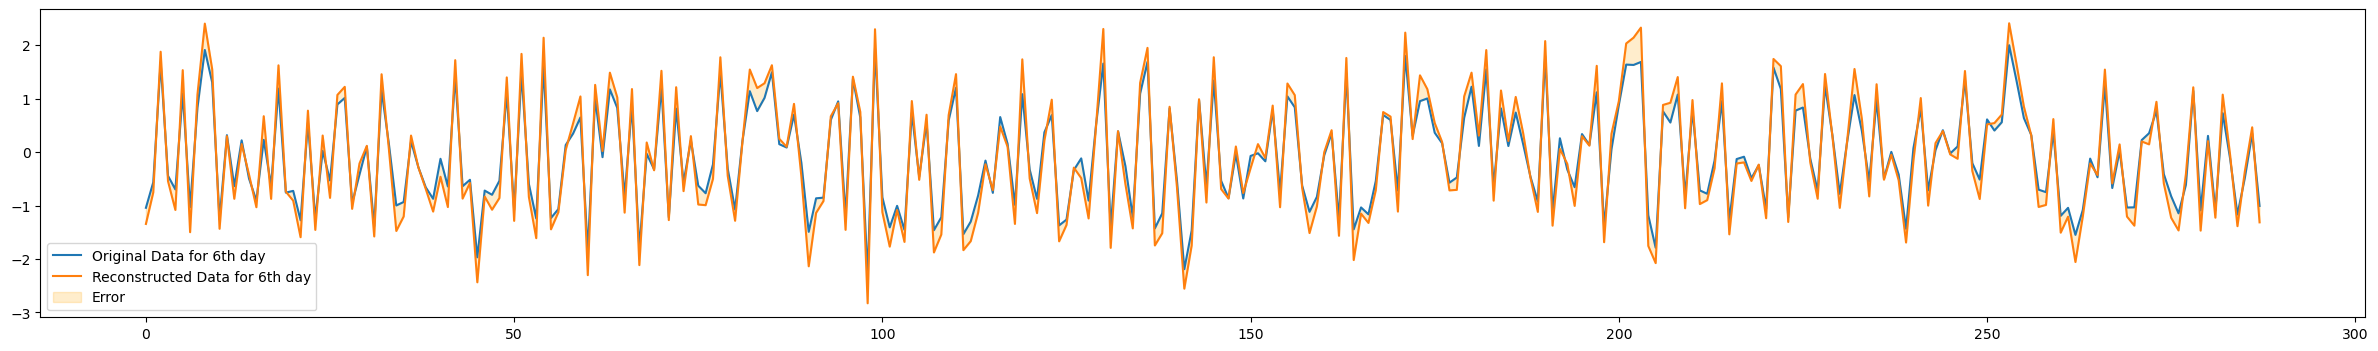

Error (MSE):  0.07016533


In [35]:
# Converting X_train to tensor
if isinstance(X_train, np.ndarray):
    X_train_tensor = torch.from_numpy(X_train).float()
else:
    X_train_tensor = X_train.float()  

# Converting X_test to tensor
if isinstance(X_test, np.ndarray):
    X_test_tensor = torch.from_numpy(X_test).float()
else:
    X_test_tensor = X_test.float() 


encoded_data = dense.encoder(X_train_tensor).detach()
decoded_data = dense.decoder(encoded_data).detach()

i = 0
X_train_np = X_train_tensor.cpu().numpy() if X_train_tensor.is_cuda else X_train_tensor.numpy()
decoded_data_np = decoded_data.cpu().numpy() if decoded_data.is_cuda else decoded_data.numpy()


X_train_np = X_train_tensor.numpy()
decoded_data_np = decoded_data.numpy()

plt.figure(figsize=(30,4))
plt.plot(X_train_np[i], label='Original Data for 6th day')
plt.plot(decoded_data_np[i], label='Reconstructed Data for 6th day')
plt.fill_between(np.arange(len(X_train_np[i])), decoded_data_np[i], X_train_np[i], color='orange', alpha=0.2, label='Error')
plt.legend()
plt.show()

# Calculate the error (MSE)
mse_error = np.mean((X_train_np[i] - decoded_data_np[i]) ** 2)
print('Error (MSE): ', mse_error)

### Dense with activation function

In [36]:
dim_hidden1 = 144
dim_hidden2 = 72
dim_hidden3 = 36
dim_hidden4 = 18
dim_hidden5 = 9

class AutoencoderAF(nn.Module):
    def __init__(self):
        super(AutoencoderAF, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(288, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_hidden3),
            nn.Tanh(),
            nn.Linear(dim_hidden3, dim_hidden4),
            nn.Tanh(),
            nn.Linear(dim_hidden4, dim_hidden5),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden5, dim_hidden4),
            nn.Tanh(),
            nn.Linear(dim_hidden4, dim_hidden3),
            nn.Tanh(),
            nn.Linear(dim_hidden3, dim_hidden2),
            nn.Tanh(),
            nn.Linear(dim_hidden2, dim_hidden1),
            nn.Tanh(),
            nn.Linear(dim_hidden1, 288),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [37]:
af = AutoencoderAF()
criterion_af = nn.MSELoss()
optimizer_af = optim.Adam(af.parameters(), lr=0.01)
batch_size = 20
epochs = 50

train_losses, val_losses, train_r2, val_r2 = train(af, train_loader, val_loader, criterion_af, optimizer_af, epochs)


 Training started
epoch =    0 
Train loss = 0.1118
val loss 56854294036480.0
epoch =    1 
Train loss = 0.1111
val loss 56854294036480.0
epoch =    2 
Train loss = 0.1068
val loss 56854294036480.0
epoch =    3 
Train loss = 0.0971
val loss 56854294036480.0
epoch =    4 
Train loss = 0.1105
val loss 56854294036480.0
epoch =    5 
Train loss = 0.0967
val loss 56854294036480.0
epoch =    6 
Train loss = 0.0953
val loss 56854294036480.0
epoch =    7 
Train loss = 0.0902
val loss 56854294036480.0
epoch =    8 
Train loss = 0.0914
val loss 56854294036480.0
epoch =    9 
Train loss = 0.0856
val loss 56854294036480.0
epoch =   10 
Train loss = 0.0875
val loss 56854294036480.0
epoch =   11 
Train loss = 0.0806
val loss 56854294036480.0
epoch =   12 
Train loss = 0.0788
val loss 56854294036480.0
epoch =   13 
Train loss = 0.0758
val loss 56854294036480.0
epoch =   14 
Train loss = 0.0715
val loss 56854294036480.0
epoch =   15 
Train loss = 0.0711
val loss 56854294036480.0
epoch =   16 
Train l

In [38]:
# Computing Test loss
af.eval()

with torch.no_grad():
    X_reconstructed = af(X_test_tensor)
    test_loss = criterion_af(X_reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")
    X_reconstructed_flat = X_reconstructed.view(-1).cpu().numpy()
    X_test_flat = X_test_tensor.view(-1).cpu().numpy()
    r2 = r2_score(X_test_flat, X_reconstructed_flat)
    print(f"R2 Score: {r2}")
    # print(r2_score(X_reconstructed.detach().cpu().numpy(), X_test_tensor.detach().cpu().numpy()))


Test Loss: 1.9293618202209473
R2 Score: -0.2706772370692123


In [39]:
reconstruction_errors = []
af.eval()
with torch.no_grad():
    for data in val_loader:
        reconstructed = af(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())
        
threshold = np.quantile(reconstruction_errors, 0.95)

anomalies_val = []
with torch.no_grad():
    for data in val_loader:
        reconstructed = af(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_val.extend(is_anomaly.cpu().numpy())
print(np.array(dates_val[anomalies_val]))

['2014-04-11']


In [40]:
anomalies_test = []
with torch.no_grad():
    for data in test_loader:
        reconstructed = af(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_test.extend(is_anomaly.cpu().numpy())
print(np.array(dates_test[anomalies_test]))

[]


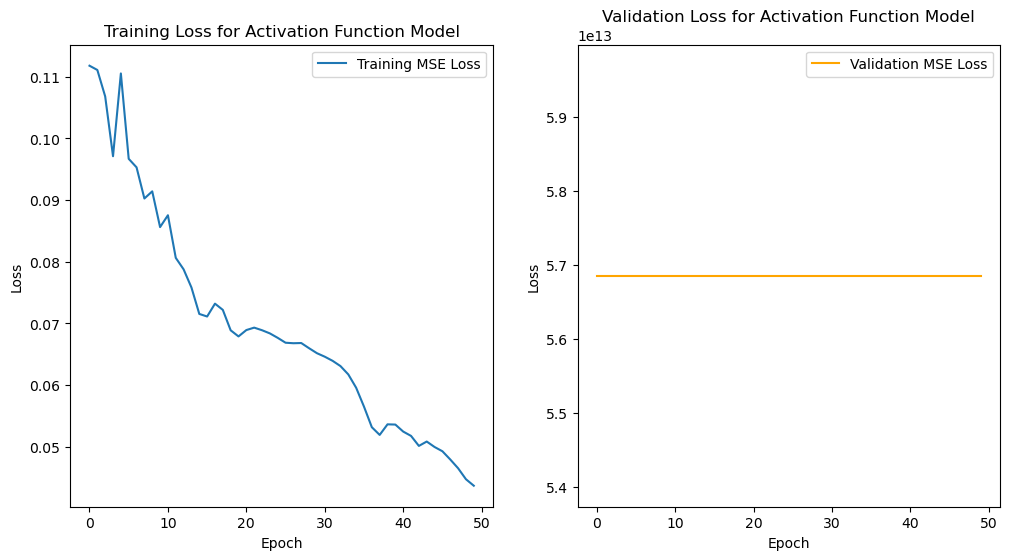

In [41]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(train_losses, label='Training MSE Loss')
ax[0].set_title('Training Loss for Activation Function Model')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_losses, label='Validation MSE Loss', color='orange')
ax[1].set_title('Validation Loss for Activation Function Model')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

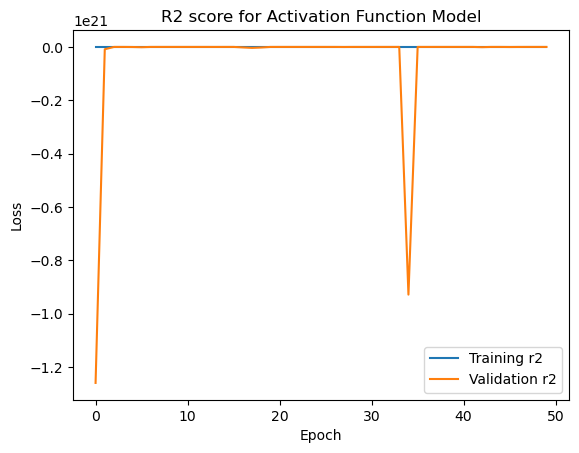

In [42]:
plt.plot(train_r2, label='Training r2')
plt.plot(val_r2, label='Validation r2')
plt.title('R2 score for Activation Function Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

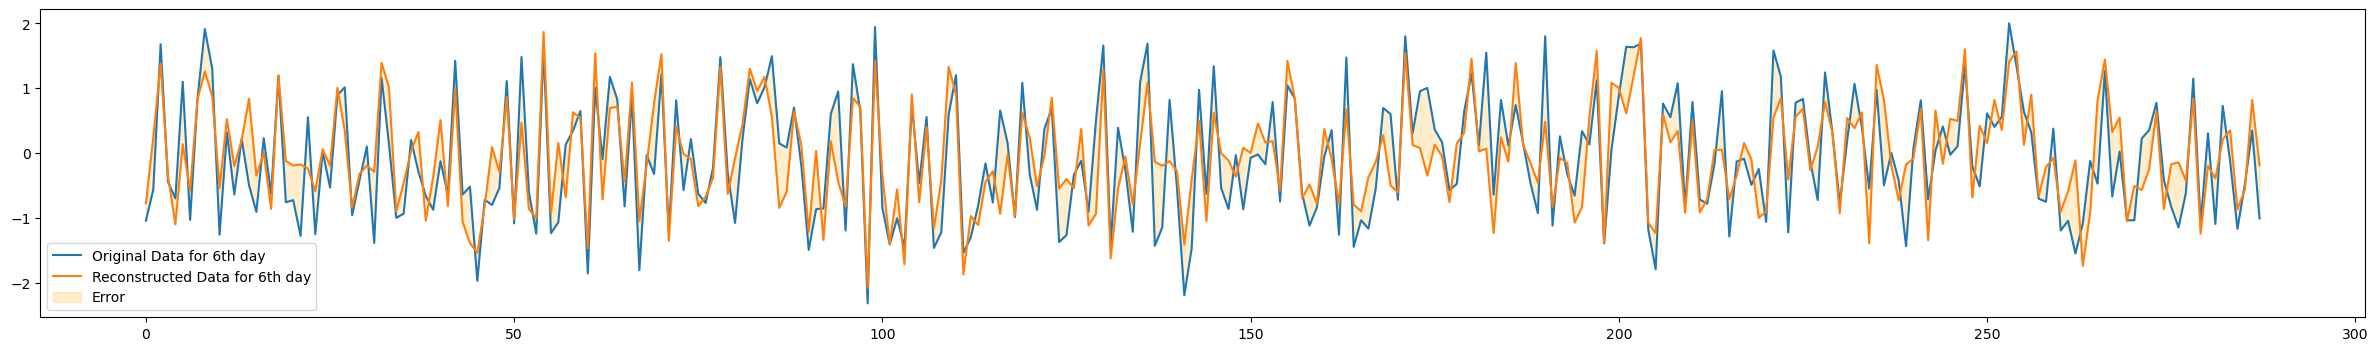

Error (MSE):  0.33477625


In [43]:
# Converting X_train to tensor
if isinstance(X_train, np.ndarray):
    X_train_tensor = torch.from_numpy(X_train).float()
else:
    X_train_tensor = X_train.float()  

# Converting X_test to tensor
if isinstance(X_test, np.ndarray):
    X_test_tensor = torch.from_numpy(X_test).float()
else:
    X_test_tensor = X_test.float() 


encoded_data = af.encoder(X_train_tensor).detach()
decoded_data = af.decoder(encoded_data).detach()

i = 0
X_train_np = X_train_tensor.cpu().numpy() if X_train_tensor.is_cuda else X_train_tensor.numpy()
decoded_data_np = decoded_data.cpu().numpy() if decoded_data.is_cuda else decoded_data.numpy()


X_train_np = X_train_tensor.numpy()
decoded_data_np = decoded_data.numpy()

plt.figure(figsize=(30,4))
plt.plot(X_train_np[i], label='Original Data for 6th day')
plt.plot(decoded_data_np[i], label='Reconstructed Data for 6th day')
plt.fill_between(np.arange(len(X_train_np[i])), decoded_data_np[i], X_train_np[i], color='orange', alpha=0.2, label='Error')
plt.legend()
plt.show()

# Calculate the error (MSE)
mse_error = np.mean((X_train_np[i] - decoded_data_np[i]) ** 2)
print('Error (MSE): ', mse_error)

### Dropout

In [44]:
dim_hidden1 = 144
dim_hidden2 = 72
dim_hidden3 = 36
dim_hidden4 = 18
dim_hidden5 = 9

class AutoencoderDropout(nn.Module):
    def __init__(self):
        super(AutoencoderDropout, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(288, dim_hidden1),
            nn.ReLU(),
            nn.Linear(dim_hidden1, dim_hidden2),
            nn.ReLU(),
            nn.Linear(dim_hidden2, dim_hidden3),
            nn.ReLU(),
            nn.Linear(dim_hidden3, dim_hidden4),
            nn.ReLU(),
            nn.Linear(dim_hidden4, dim_hidden5),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(dim_hidden5, dim_hidden4),
            nn.ReLU(),
            nn.Linear(dim_hidden4, dim_hidden3),
            nn.ReLU(),
            nn.Linear(dim_hidden3, dim_hidden2),
            nn.ReLU(),
            nn.Linear(dim_hidden2, dim_hidden1),
            nn.ReLU(),
            nn.Linear(dim_hidden1, 288),
            nn.Dropout(0.3),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [45]:
dropout = AutoencoderDropout()
criterion_drop = nn.MSELoss()
optimizer_drop = optim.Adam(dropout.parameters(), lr=0.01)
batch_size = 20
epochs = 50

train_losses, val_losses, train_r2, val_r2 = train(dropout, train_loader, val_loader, criterion_drop, optimizer_drop, epochs)


 Training started
epoch =    0 
Train loss = 0.1116
val loss 56854331785216.0
epoch =    1 
Train loss = 0.1116
val loss 56853526478848.0
epoch =    2 
Train loss = 0.1115
val loss 56857276186624.0
epoch =    3 
Train loss = 0.1113
val loss 56860392554496.0
epoch =    4 
Train loss = 0.1111
val loss 56865035649024.0
epoch =    5 
Train loss = 0.1102
val loss 56862305157120.0
epoch =    6 
Train loss = 0.1070
val loss 56831258918912.0
epoch =    7 
Train loss = 0.0989
val loss 57266183077888.0
epoch =    8 
Train loss = 0.1113
val loss 56657887363072.0
epoch =    9 
Train loss = 0.0906
val loss 56562718605312.0
epoch =   10 
Train loss = 0.0943
val loss 56508628860928.0
epoch =   11 
Train loss = 0.0963
val loss 56416215760896.0
epoch =   12 
Train loss = 0.0956
val loss 56305364500480.0
epoch =   13 
Train loss = 0.0938
val loss 56309806268416.0
epoch =   14 
Train loss = 0.0935
val loss 56271906537472.0
epoch =   15 
Train loss = 0.0899
val loss 56333940293632.0
epoch =   16 
Train l

In [46]:
# Computing Test loss
dropout.eval()

with torch.no_grad():
    X_reconstructed = dropout(X_test_tensor)
    test_loss = criterion_drop(X_reconstructed, X_test_tensor)
    print(f"Test Loss: {test_loss.item()}")
    X_reconstructed_flat = X_reconstructed.view(-1).cpu().numpy()
    X_test_flat = X_test_tensor.view(-1).cpu().numpy()
    r2 = r2_score(X_test_flat, X_reconstructed_flat)
    print(f"R2 Score: {r2}")
    # print(r2_score(X_reconstructed.detach().cpu().numpy(), X_test_tensor.detach().cpu().numpy()))


Test Loss: 2.024054527282715
R2 Score: -0.3330420200650692


In [47]:
reconstruction_errors = []
dropout.eval()
with torch.no_grad():
    for data in val_loader:
        reconstructed = dropout(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        reconstruction_errors.extend(loss.cpu().numpy())
        
threshold = np.quantile(reconstruction_errors, 0.95)

anomalies_val = []
with torch.no_grad():
    for data in val_loader:
        reconstructed = dropout(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_val.extend(is_anomaly.cpu().numpy())
print(np.array(dates_val[anomalies_val]))

['2014-04-11']


In [48]:
anomalies_test = []
with torch.no_grad():
    for data in test_loader:
        reconstructed = dropout(data)
        loss = torch.mean((data - reconstructed) ** 2, dim=1)
        is_anomaly = loss > threshold
        anomalies_test.extend(is_anomaly.cpu().numpy())
print(np.array(dates_test[anomalies_test]))

[]


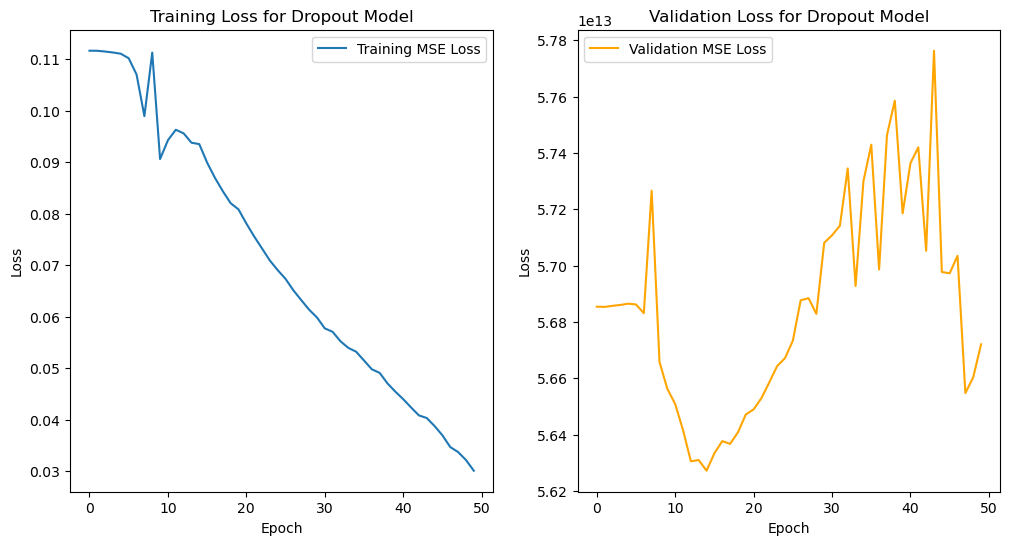

In [49]:
fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(train_losses, label='Training MSE Loss')
ax[0].set_title('Training Loss for Dropout Model')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[1].plot(val_losses, label='Validation MSE Loss', color='orange')
ax[1].set_title('Validation Loss for Dropout Model')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.show()

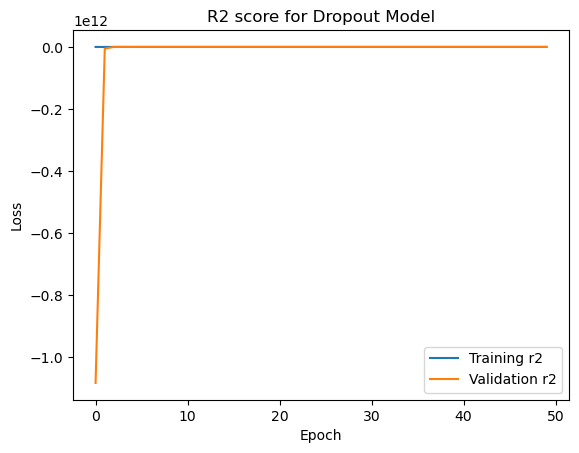

In [50]:
plt.plot(train_r2, label='Training r2')
plt.plot(val_r2, label='Validation r2')
plt.title('R2 score for Dropout Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

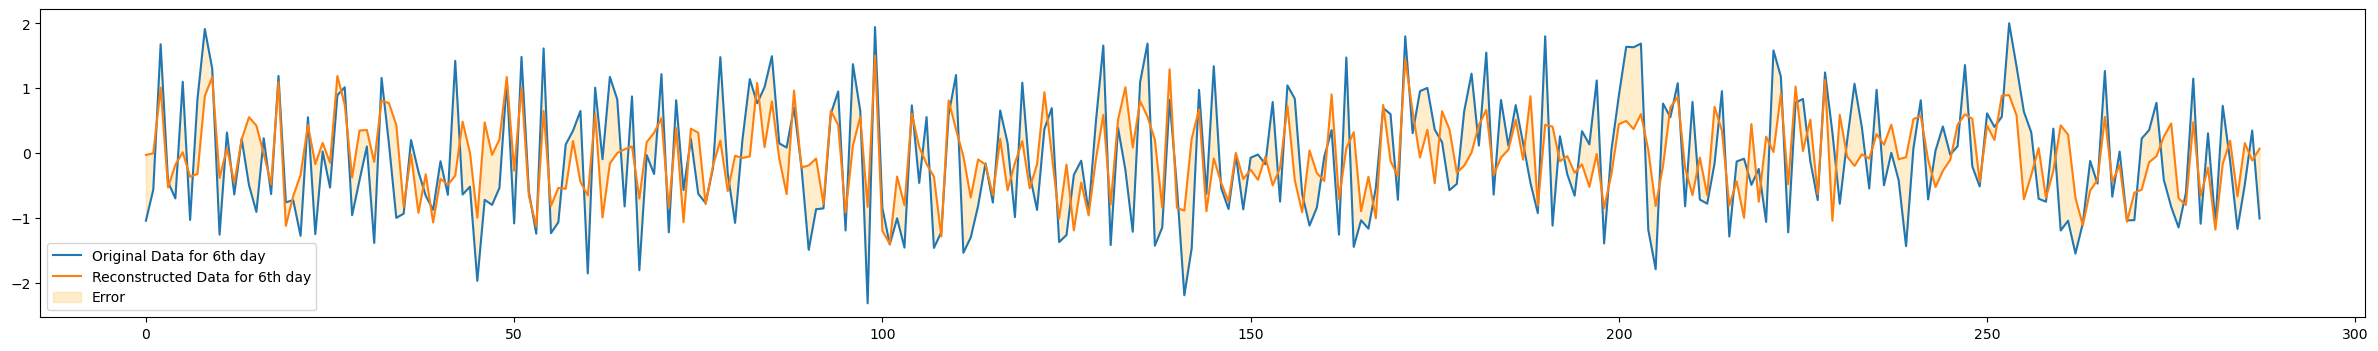

Error (MSE):  0.563371


In [51]:
# Converting X_train to tensor
if isinstance(X_train, np.ndarray):
    X_train_tensor = torch.from_numpy(X_train).float()
else:
    X_train_tensor = X_train.float()  

# Converting X_test to tensor
if isinstance(X_test, np.ndarray):
    X_test_tensor = torch.from_numpy(X_test).float()
else:
    X_test_tensor = X_test.float() 


encoded_data = dropout.encoder(X_train_tensor).detach()
decoded_data = dropout.decoder(encoded_data).detach()

i = 0
X_train_np = X_train_tensor.cpu().numpy() if X_train_tensor.is_cuda else X_train_tensor.numpy()
decoded_data_np = decoded_data.cpu().numpy() if decoded_data.is_cuda else decoded_data.numpy()


X_train_np = X_train_tensor.numpy()
decoded_data_np = decoded_data.numpy()

plt.figure(figsize=(30,4))
plt.plot(X_train_np[i], label='Original Data for 6th day')
plt.plot(decoded_data_np[i], label='Reconstructed Data for 6th day')
plt.fill_between(np.arange(len(X_train_np[i])), decoded_data_np[i], X_train_np[i], color='orange', alpha=0.2, label='Error')
plt.legend()
plt.show()

# Calculate the error (MSE)
mse_error = np.mean((X_train_np[i] - decoded_data_np[i]) ** 2)
print('Error (MSE): ', mse_error)

### Saving the best model

In [52]:
torch.save(autoencoder.state_dict(), 'cnara_kushakum_assignment2_part2.pth')

### Contribution
<h5>Charan Kumar Nara:     50%</h5>
<h5>Kusha Kumar Dharavath: 50%</h5>